# Detecting changes in vegetation structure following fires using discrete-return LiDAR

The **Creek Fire** was a large wildfire which started in September, 2020, in the Sierra National Forest, California, and became one of the largest fires of the [2020 California wildfire season](https://en.wikipedia.org/wiki/2020_California_wildfires). This fire had burned into NEON's [Soaproot Saddle site (SOAP)](https://www.neonscience.org/field-sites/soap) by mid-month, causing a [high intensity burn over much of the site](https://www.neonscience.org/impact/observatory-blog/domain-digest-no-4-fire-field-sites-and-recovery) - standing trees became charcoal spires, shrubs and their root systems burned completely, the thick litter layer was incinerated, and the soil severely burned.

The NEON Airbone Obervation Platform (AOP) conducted aerial surveys for the SOAP site in 2019 and 2021, a year before and after the Creek Fire. The goal of this exercise is to study the effects of fire on vegetation structure by comparing the lidar-derived relative height percentiles before (2019) and after (2021) the fire. In addition to the discrete return data, this tutorial uses a Digital Terrain Model (DTM) to determine the relative height of the discrete return with respect to ground.

This python tutorial covers the following:
1. Read the NEON discrete-return lidar data ([DP1.30003.001](https://data.neonscience.org/data-products/DP1.30003.001)) and the lidar-derived Digital Terrain Model ([DP3.30024.001](https://data.neonscience.org/data-products/DP3.30024.001)) in python. 
2. Visualize the 3d lidar point cloud. Compare the spatial extent of the lidar data used in this tutorial with that of the creek fire perimeter and the SOAP site boundary.
3. Calculate and compare the relative height percentiles (25$^{th}$, 50$^{th}$, 75$^{th}$ percentile heights etc.) before and after the 2020 Creek fire. 


### Data
The data used in this tutorial is available on this [Google Drive link](https://drive.google.com/drive/folders/1b-hU4ZgW32gMLzP3_qkv5H2PrXHcY2hL?usp=sharing). This folder contains shapefiles for the Creek Fire perimeter, kml file for the Soaproot site boundary, discrete-return lidar data for the years 2019 and 2021 in .laz format for a small fire-affected area within the SOAP site, and DTM data in .tif format for the same area. The unzipped folder has a size of about 113 MB. 

### Python packages used 
* **rasterio & rioxarray** for reading and plotting raster data
* **geopandas** for reading shapefiles and kml 
* **laspy** for reading lidar point cloud
* **pptk** for visualizing 3d lidar point cloud
* **pyproj** to change map projections 
* **shapely** to create vector polygons
* **seaborn** for making boxplots and histograms

To install each of these python packages, run the command "pip install " followed by the name of the package on the terminal.

### Other NEON tutorials on discrete-return lidar
* If you're interested in using the NEON API to download lidar data using just a few lines of code, please refer to this [python tutorial](https://www.neonscience.org/resources/learning-hub/tutorials/neon-discrete-point-clouds).
* For a more general indroduction to lidar and how to process lidar data in R, please follow this [R Tutorial series](https://www.neonscience.org/resources/learning-hub/tutorials/introduction-light-detection-and-ranging-lidar-explore-point#toggle-0). 
* You may also refer to this [R tutorial](https://www.neonscience.org/resources/learning-hub/tutorials/structural-diversity-discrete-return) on calculating forest structural diversity metrics for different NEON sites. 

## Part 1: Reading lidar data

In [305]:
## Import all python packages needed for this tutorial
import pandas as pd
import numpy as np
import laspy, os, glob
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pyproj
import shapely
import seaborn as sns
import rasterio, rioxarray
import pptk

### Read las files in python

In [285]:
## Download the Google drive folder with all the data onto your local machine. Link in description above.
## Move into the "Discrete_return_lidar_returns" folder and import the point cloud data for 2019 and 2021.
## Change the path to the directory when running the code on your local machine
os.chdir("D://NEON_lidar_tutorial_datasets/NEON_lidar_tutorial_datasets/Discrete_return_lidar_returns/")
las_2021 = laspy.read("NEON_D17_SOAP_DP1_293000_4097000_classified_point_cloud_colorized_2021.laz")
las_2019 = laspy.read("NEON_D17_SOAP_DP1_293000_4097000_classified_point_cloud_colorized_2019.laz")

## Print all the fields provided by the las files
print(list(las_2021.point_format.dimension_names))

['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time', 'red', 'green', 'blue']


### Read point cloud data as a dataframe

The "las_to_df" function defined below imports the .las file as a python dataframe. For more information about the las format, please refer to the [ASPRS documentation](https://www.asprs.org/wp-content/uploads/2010/12/LAS_1_4_r13.pdf). Las files provide the following information:
 * X, Y and Z (height above ellipsoid) coordinates of the discrete return.
 * Intensity of the return.
 * Return number and total number of returns per pulse. Each lidar pulse can have multiple returns along the vertical profile. The first return typically comes from the top of the canopy while the last return tends to be from the ground.
 * Classification of the return. Lastools software follows the [standard ASPRS classification](https://www.asprs.org/wp-content/uploads/2010/12/LAS_1_4_r13.pdf) scheme to classify returns as ground, low vegetation, high vegetation, buildings etc.
 * Scan angle of the lidar sensor at which the return was collected (can vary from -18 degrees to + 18 degrees). This information could be used to drop returns collected at extreme values of scan angle.
 
For more information about how the lidar point clouds were created, refer to the "NEON L0-to-L1 Discrete Return LiDAR Algorithm Theoretical Basis Document (ATBD)" found on the [NEON data product page](https://data.neonscience.org/data-products/DP1.30003.001). You may also refer to this [tutorial series](https://www.neonscience.org/resources/learning-hub/tutorials/introduction-light-detection-and-ranging-lidar-explore-point#toggle-0)

In [74]:
## Function to import las file as a dataframe in python
def las_to_df(las):
  x = pd.DataFrame(np.array(las.x))
  y = pd.DataFrame(np.array(las.y))
  z = pd.DataFrame(np.array(las.z))
  intensity = pd.DataFrame(np.array(las.intensity))
  return_num = pd.DataFrame(np.array(las.return_number))
  number_of_returns = pd.DataFrame(np.array(las.number_of_returns))
  classification = pd.DataFrame(np.array(las.classification)) ## 0 - 31 as per ASPRS classification scheme
    
  df = pd.concat([x, y, z, intensity, return_num, number_of_returns, classification], axis=1)
  df.columns=["x", "y", "z", "intensity", "return_num", "number_of_returns", "classification"]
  return(df)

In [353]:
## Call the las_to_df function to extract the 2019 and 2021 data as separate dataframes
point_cloud_df_2019 = las_to_df(las_2019)
point_cloud_df_2021 = las_to_df(las_2021)
point_cloud_df_2021.head()

,x,y,z,intensity,return_num,number_of_returns,classification
0,293324.039,4097000.032,567.007,92,1,1,2
1,293323.314,4097000.029,567.048,137,1,1,2
2,293322.605,4097000.023,567.131,124,1,1,2
3,293321.856,4097000.028,567.076,161,1,1,2
4,293321.039,4097000.053,566.778,91,1,1,2


### Read the Digital Terrain Model (DTM) data

Discrete return heights (Z elevations) are specified with respect to a reference datum. We will be using the ground elevations from DTM to calculate the relative height of the discrete returns with respect to ground. 

In [138]:
## Go inside the "Digital_Terrain_Model" folder and import the DTM tifs
os.chdir("D://NEON_lidar_tutorial_datasets/NEON_lidar_tutorial_datasets/Digital_Terrain_Model/")
DTM_2019 = rasterio.open("NEON_D17_SOAP_DP3_293000_4097000_DTM_2019.tif")
DTM_2021 = rasterio.open("NEON_D17_SOAP_DP3_293000_4097000_DTM_2021.tif")

It's always a good idea to check the metadata of the DTM raster at the time of data ingestion. You can access the metadata using the .tags() option.

In [282]:
## Check metadata for 2019 DTM 
for item in DTM_2019.tags():
    print(item + ":" + DTM_2019.tags()[item])

AREA_OR_POINT:Area
TIFFTAG_ARTIST:Created by the National Ecological Observatory Network (NEON)
TIFFTAG_COPYRIGHT:The National Ecological Observatory Network is a project sponsored by the National Science Foundation and managed under cooperative agreement by Battelle Ecology. This material is based in part upon work supported by the National Science Foundation under Grant No. DBI-0752017.
TIFFTAG_DATETIME:Flown on 2019061115, 2019061315, 2019061415, 2019061515, 2019061516, 2019061615-P2C1
TIFFTAG_IMAGEDESCRIPTION:Elevation LiDAR - NEON.DP3.30024 acquired at SOAP by Optech, Inc Gemini 12SEN311 as part of P2C1
TIFFTAG_MAXSAMPLEVALUE:682
TIFFTAG_MINSAMPLEVALUE:569
TIFFTAG_RESOLUTIONUNIT:2 (pixels/inch)
TIFFTAG_SOFTWARE:Tif file created with a Matlab script (write_gtiff.m) written by Tristan Goulden (tgoulden@battelleecology.org) with data processed from the following scripts: create_tiles_from_mosaic.m, combine_DTM_DSM_gtif.m, LasTools_workflow.csh which implemented LAStools version 19072

In [283]:
## Check metadata for 2021 DTM
for item in DTM_2021.tags():
    print(item + ":" + DTM_2021.tags()[item])

AREA_OR_POINT:Area
TIFFTAG_ARTIST:Created by the National Ecological Observatory Network (NEON)
TIFFTAG_COPYRIGHT:The National Ecological Observatory Network is a project sponsored by the National Science Foundation and managed under cooperative agreement by Battelle. This material is based in part upon work supported by the National Science Foundation under Grant No. DBI-0752017.
TIFFTAG_DATETIME:Flown on 2021071215, 2021071315-P1C2
TIFFTAG_IMAGEDESCRIPTION:Elevation LiDAR - NEON.DP3.30024 acquired at SOAP by Teledyne Optech Galaxy Prime 5060445 as part of P1C2
TIFFTAG_MAXSAMPLEVALUE:682
TIFFTAG_MINSAMPLEVALUE:566
TIFFTAG_RESOLUTIONUNIT:2 (pixels/inch)
TIFFTAG_SOFTWARE:Tif file created with a Matlab script (write_gtiff.m) written by Tristan Goulden (tgoulden@battelleecology.org) with data processed from the following scripts: create_tiles_from_mosaic.m, combine_dtm_dsm_gtif.m, lastools_workflow.csh which implemented LAStools version 210418.
TIFFTAG_XRESOLUTION:1
TIFFTAG_YRESOLUTION:1


As per the information provided in the 'TIFFTAG_IMAGEDESCRIPTION' field in the metadata, it can be seen that NEON flew the old Optech Gemini lidar sensor in 2019 and the new Optech Galaxy Prime sensor in 2021. When comparing lidar data collected across different years, it is important to check if the lidar sensors used for the collections are consistent across years. Older sensors like the Optech Gemini have a wider outgoing pulse width, which results in poorer range resolution compared to the newer Optech Galaxy Prime. **Poor range resolution for a lidar sensor makes it difficult to resolve objects that are close to the ground (such as low vegetation).** Optech Gemini has a range resolution of about 2 m, which means that it can be challenging to distinguish objects that are less than 2 m apart along the vertical profile. The range resolution for the newer Optech Galaxy prime is substantially better, at around 67 cm. 

In [284]:
## Ingest DTM as a numpy array
DTM_2019_arr = DTM_2019.read(1)
DTM_2021_arr = DTM_2021.read(1)

print(DTM_2021_arr)
print(" ")
print("Number of rows in the DTM array is %d" %DTM_2021_arr.shape[0])
print("Number of columns in the DTM array is %d" %DTM_2021_arr.shape[1])

[[617.103 617.088 617.04  ... 681.869 682.16  682.455]
 [616.992 616.966 616.943 ... 681.567 681.889 682.309]
 [616.9   616.9   616.794 ... 681.243 681.725 682.125]
 ...
 [621.67  621.621 621.484 ... 656.604 656.828 657.036]
 [622.128 621.906 621.759 ... 656.751 657.011 657.159]
 [622.553 622.362 622.171 ... 656.915 657.115 657.435]]
 
Number of rows in the DTM array is 1000
Number of columns in the DTM array is 1000


## Part 2: Data Visualization

### Create 3d visualization of discrete-return point cloud using pptk library 

Here we'll visualize the discrete returns in three dimensions. Laspy has limited options for visualization, so we will be using the pptk library. To visualize the 3D point cloud data, we first stack the X, Y, and Z dimensions using Numpy (np.stack). We them import the pptk library, pass the stacked point data, and colorize each discrete-return.  

In [ ]:
## Plot 3D point cloud
## Use np.stack to combine the X, Y and Z into one array
## Convert (3 x n) array to (n x 3) using transpose
point_data_2021 = np.stack([las_2021.X, las_2021.Y, las_2021.Z]).transpose() 
point_data_2019 = np.stack([las_2019.X, las_2019.Y, las_2019.Z]).transpose()

## Extract the Red (R),Green (G), Blue (B) values associated with each discrete return
## The R,G,B values are obtained from the camera sensor fitted on the airplane
## Think of this as "draping" the camera imagery on top of the lidar discrete-returns
colors_2021 = np.stack([las_2021.red, las_2021.green, las_2021.blue]).transpose()
colors_2019 = np.stack([las_2019.red, las_2019.green, las_2019.blue]).transpose()
print("Number of discrete returns in the 2021 point cloud file = %s" %"{:,}".format(point_data_2021.shape[0]))
print("Number of discrete returns in the 2019 point cloud file = %s" %"{:,}".format(point_data_2019.shape[0]))

## Visualize the 2021 point cloud using pptk package
pc_2021 = pptk.viewer(point_data_2021)
## Our color values are coded on 16 bits in the las file.
## We need to scale it to [0,1]; thus we divide it by 65535
pc_2021.attributes(colors_2021/65535)

## Similar for 2019 point cloud data
pc_2019 = pptk.viewer(point_data_2019)
pc_2019.attributes(colors_2019/65535)

When you run the above chunk of code, the 3d point clouds for the years 2019 and 2021 get visualized in separate pop-up windows. Just a visual comparison of the colorized point cloud from the two years reveals burn scars and greater gaps in vegetation in the year 2021.  

### Plot the 2021 DTM 

In [340]:
## Here, we're going to explore yet another python library called rioxarray for reading and plotting raster data
os.chdir("D://NEON_lidar_tutorial_datasets/NEON_lidar_tutorial_datasets/Digital_Terrain_Model/")
dtm = rioxarray.open_rasterio("NEON_D17_SOAP_DP3_293000_4097000_DTM_2021.tif")
print(dtm)

<xarray.DataArray (band: 1, y: 1000, x: 1000)>
[1000000 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 2.93e+05 2.93e+05 2.93e+05 ... 2.94e+05 2.94e+05
  * y            (y) float64 4.098e+06 4.098e+06 ... 4.097e+06 4.097e+06
    spatial_ref  int32 0
Attributes:
    _FillValue:    -9999.0
    scale_factor:  1.0
    add_offset:    0.0


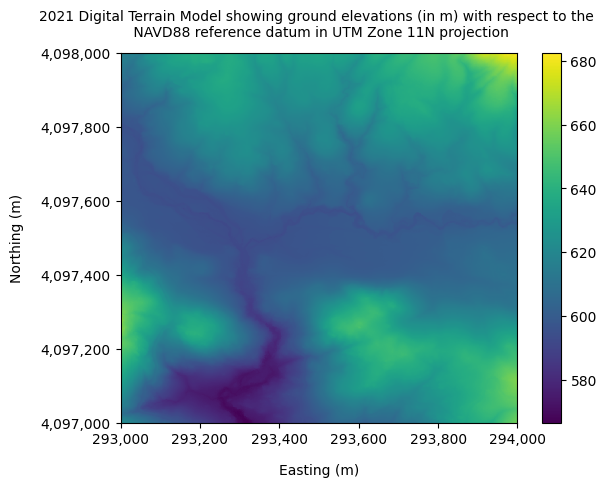

In [341]:
dtm.plot()
plt.title("2021 Digital Terrain Model showing ground elevations (in m) with respect to the \n NAVD88 reference datum in UTM Zone 11N projection", fontsize=10, pad=12)
plt.ylabel("Northing (m)", labelpad=12)
plt.xlabel("Easting (m)", labelpad=12)

xticks = np.arange(293000, 294200, 200)
comma_sep_xticks = []
for num in xticks:
   comma_sep_num = "{:,}".format(num)
   comma_sep_xticks.append(comma_sep_num)

yticks = np.arange(4097000,4098200,200)
comma_sep_yticks = []
for num in yticks:
   comma_sep_num = "{:,}".format(num)
   comma_sep_yticks.append(comma_sep_num)
    
plt.xticks(xticks, comma_sep_xticks)
plt.yticks(yticks, comma_sep_yticks)

plt.show()

### Visualize the relative spatial extent of the lidar data used in relation to the Creek Fire perimeter

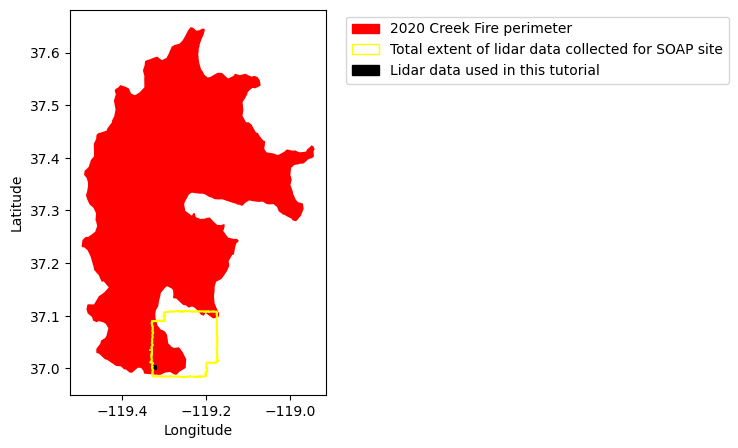

In [348]:
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from rasterio.plot import show
import warnings
warnings.filterwarnings('ignore')

## Go inside the creek fire boundary subfolder and ingest the shape file
os.chdir("D://NEON_lidar_tutorial_datasets/NEON_lidar_tutorial_datasets/Creek_fire_boundary/") 
creek_fire_perimeter = gpd.read_file("creek_fire_perimeter.shp")

## Now go into the Soaproot site boundary subfolder and ingest the kml file
os.chdir("D://NEON_lidar_tutorial_datasets/NEON_lidar_tutorial_datasets/SOAP_site_boundary/")
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'  ## Make geopandas read a kml file
soap_boundary = gpd.read_file("NEON_D17_SOAP_DPQA_2021_full_boundary.kml", driver='KML')

## Plot the extents of the 2020 Creek Fire and the SOAP site boundary
creek_fire = creek_fire_perimeter.plot(color='red', figsize=(3.5,5))
soap_boundary.plot(ax=creek_fire, color='yellow')
plt.xlabel("Longitude")
plt.ylabel("Latitude")

## Now let's also plot the extent of 2021 DTM
## DTM is available in UTM Zone 11N projection whereas the shapefiles are not projected
## This difference in projection systems prevents us from plotting the DTM and the shapefiles together
## We will be using Pyproj package to convert the UTM coordinates of the DTM bounding box to lat lon
## Then we will use shapely package to create a polygon whose corners are the lat lon values of the DTM bounding box

from pyproj import Proj  ## Install pyproj by running 'pip install pyproj' on the terminal
utm_proj = Proj("+proj=utm +zone=11 +north +ellps=WGS84 +datum=WGS84 +units=m")
lon_min, lat_min = utm_proj(DTM_2021.bounds[0], DTM_2021.bounds[1], inverse=True)
lon_max, lat_max = utm_proj(DTM_2021.bounds[2], DTM_2021.bounds[3], inverse=True)

corner_coords = [[lon_min, lat_min], [lon_min, lat_max], [lon_max, lat_max], [lon_max, lat_min]]

## Create a shapely polygon using corner coordinates
from shapely import Polygon ## Install shapely using 'pip install shapely' on the terminal
polygon_geometry = Polygon(corner_coords)
df = {'Attribute':['DTM_extent'], 'geometry':polygon_geometry} # create a dictionary with needed attributed
dtm_polygon = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')
dtm_polygon.plot(color='black', ax=creek_fire)

## Add legend
legend_elements = [Patch(facecolor='red', edgecolor='red', label='2020 Creek Fire perimeter'), 
                  Patch(facecolor='none', edgecolor='yellow', label='Total extent of lidar data collected for SOAP site'),
                  Patch(facecolor='black', edgecolor='black', label='Lidar data used in this tutorial')]
plt.legend(handles=legend_elements, bbox_to_anchor=(2.6,1))
plt.show()

## Part 3: Calculate and compare the relative height percentiles on a pixel-wise basis before (2019) and after (2021) the 2020 Creek fire.

We will now be calculating pixel-wise height percentiles relative to the Digital Terrain Model (DTM). To ensure that we have sufficient number of lidar returns for calculating percentiles, we will be calculating these metrics for every 5m pixel on the ground. So, our tasks here would be to:

1) Calculate relative heights of discrete returns with repect to the 1m DTM. We will be using the 2021 DTM to calculate relative heights for both the 2019 and 2021 discrete return data. The 2020 fire event would have likely cleared up some of the low vegetation and ground litter, thereby improving ground detection post-fire in 2021. The 2021 DTM could be a more accurate representation of the true ground compared to the 2019 DTM.
2) Create a 5m spatial resolution raster grid and assign a unique id to each 5m pixel.
3) Group all discrete returns based on the 5m pixel they fall into.
4) Calculate relative height percentiles for each 5m pixel and create spatial maps.

### 1. Discrete-return heights relative to 2021 1m DTM 

We will be sampling the raster values from the 2021 DTM at the x,y locations of each discrete return

In [361]:
## zip all x and y coordinates together for sampling rasters in the next cell
discrete_return_xycoords_2019 = [(x,y) for x, y in zip(point_cloud_df_2019["x"], point_cloud_df_2019["y"])]
discrete_return_xycoords_2021 = [(x,y) for x, y in zip(point_cloud_df_2021["x"], point_cloud_df_2021["y"])]

## print the first five elements of coords_2021
print(discrete_return_xycoords_2021[0:5])

[(293324.039, 4097000.032), (293323.314, 4097000.029), (293322.605, 4097000.023), (293321.856, 4097000.028), (293321.039, 4097000.053)]


In [362]:
## Sample the raster using "rasterio.sample.sample_gen()"
## This chunk of code could take a substantial amount of time to run (~15-20 min). Reduce your spatial extent to save time. 

## Sample the 2021 DTM raster for ground elevation at each (x,y) location of the 2021 discrete returns
dtm_vals_2021 = pd.DataFrame(list(rasterio.sample.sample_gen(DTM_2021, coords_2021)))

## Sample the 2021 DTM raster for ground elevation at each (x,y) location of the 2019 discrete returns
dtm_vals_2019 = pd.DataFrame(list(rasterio.sample.sample_gen(DTM_2021, coords_2019)))

In [388]:
## Merge the point cloud dataframe generated earlier (point_cloud_df_20xx) with the DTM ground elevations extracted in the previous cell
## Calculate the relative height of each return with respect to ground ("relative_height_return") 

## 2019
df_2019 = pd.concat([point_cloud_df_2019, dtm_vals_2019], axis=1)
df_2019.columns = ["x", "y", "z", "intensity", "return_num", "number_of_returns", "classification", "ground_elevation"]
df_2019["relative_height_return"] = df_2019["z"] - df_2019["ground_elevation"]

## Do the same for 2021 data as well
df_2021 = pd.concat([point_cloud_df_2021, dtm_vals_2021], axis=1)
df_2021.columns = ["x", "y", "z", "intensity", "return_num", "number_of_returns", "classification", "ground_elevation"]
df_2021["relative_height_return"] = df_2021["z"] - df_2021["ground_elevation"]
df_2021.head()

,x,y,z,intensity,return_num,number_of_returns,classification,ground_elevation,relative_height_return
0,293324.039,4097000.032,567.007,92,1,1,2,567.023010,-0.016010
1,293323.314,4097000.029,567.048,137,1,1,2,566.999023,0.048977
2,293322.605,4097000.023,567.131,124,1,1,2,567.146973,-0.015973
3,293321.856,4097000.028,567.076,161,1,1,2,567.033020,0.042980
4,293321.039,4097000.053,566.778,91,1,1,2,567.033020,-0.255020


### 2. Create a 5m spatial resolution raster grid and assign a unique id to each 5m pixel

In [380]:
## Save the new 5m raster in the DTM data folder
working_directory = "D://NEON_lidar_tutorial_datasets/NEON_lidar_tutorial_datasets/Digital_Terrain_Model/"
os.chdir(working_directory)

## Create a (200 x 200) dataframe with each cell having a unique value between 0 and 40,000  
ids = pd.DataFrame(data=np.arange(0, 200*200).reshape(200,200), index=np.arange(0,200), columns=np.arange(0,200))

## Create a scaled transform
scaled_transform = DTM_2021.transform * DTM_2021.transform.scale((5),(5))

## Using rasterio, save the dataframe as a 5m raster in the tif format 
with rasterio.open(
    working_directory + 'DTM_5m_unique_id.tif',
    'w',
    driver='GTiff',
    height=ids.shape[0],
    width=ids.shape[1],
    count=1,
    dtype=np.dtype(np.int32),
    crs=DTM_2021.crs,
    transform=scaled_transform,
) as dst:
    dst.write(ids, 1)

<xarray.DataArray (band: 1, y: 200, x: 200)>
array([[[    0,     1, ...,   198,   199],
        [  200,   201, ...,   398,   399],
        ...,
        [39600, 39601, ..., 39798, 39799],
        [39800, 39801, ..., 39998, 39999]]])
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 2.93e+05 2.93e+05 2.93e+05 ... 2.94e+05 2.94e+05
  * y            (y) float64 4.098e+06 4.098e+06 ... 4.097e+06 4.097e+06
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0


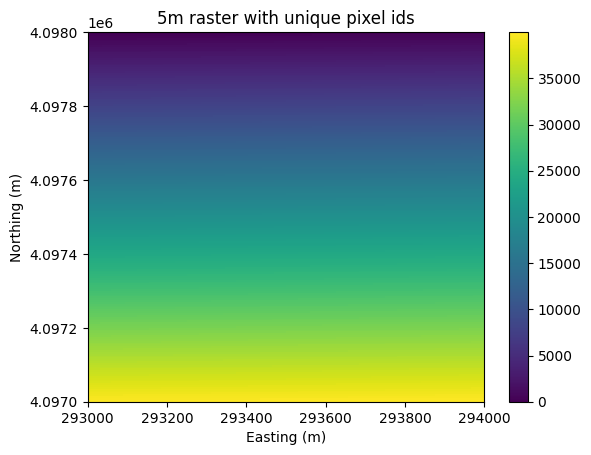

In [386]:
## Use rioxarray again to plot the newly created 5m raster
raster_5m = rioxarray.open_rasterio("DTM_5m_unique_id.tif")
print(raster_5m)
raster_5m.plot()
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.title("5m raster with unique pixel ids")
plt.show()

### 3.  Group all discrete returns based on the 5m pixel they fall into.

In [387]:
## Here, we assign unique ids to each discrete return
## Sample the unique ids from the 5m raster for each discrete return for the years 2019 and 2021
## This sampling step might again take a substantial amount of time to run

raster_5m = rasterio.open("DTM_5m_unique_id.tif")
## For the year 2021
dtm_id_vals_2021 = pd.DataFrame(list(rasterio.sample.sample_gen(raster_5m, coords_2021)))

## For the year 2019
dtm_id_vals_2019 = pd.DataFrame(list(rasterio.sample.sample_gen(raster_5m, coords_2019)))

In [394]:
## Merge the uniq ids extracted above with the discrete return dataframe created earlier

## Update 2019 df
df_2019_with_ids = pd.concat([df_2019, dtm_id_vals_2019], axis=1)
df_2019_with_ids.columns = ["x", "y", "z", "intensity", "return_num", "number_of_returns", "classification", 
                   "ground_elevation", "relative_height_return", "uniq_id"]
df_2019_with_ids = df_2019_with_ids[df_2019_with_ids["ground_elevation"] > -9999.0].reset_index(drop=True)

## Update 2021 df
df_2021_with_ids = pd.concat([df_2021, dtm_id_vals_2021], axis=1)
df_2021_with_ids.columns = ["x", "y", "z", "intensity", "return_num", "number_of_returns", "classification", 
                            "ground_elevation", "relative_height_return", "uniq_id"]
df_2021_with_ids = df_2021_with_ids[df_2021_with_ids["ground_elevation"] > -9999.0].reset_index(drop=True)
df_2021_with_ids.head()

,x,y,z,intensity,return_num,number_of_returns,classification,ground_elevation,relative_height_return,uniq_id
0,293324.039,4097000.032,567.007,92,1,1,2,567.023010,-0.016010,39864
1,293323.314,4097000.029,567.048,137,1,1,2,566.999023,0.048977,39864
2,293322.605,4097000.023,567.131,124,1,1,2,567.146973,-0.015973,39864
3,293321.856,4097000.028,567.076,161,1,1,2,567.033020,0.042980,39864
4,293321.039,4097000.053,566.778,91,1,1,2,567.033020,-0.255020,39864


Before we go ahead to calculate the relative height percentiles, let's look at the distribution of the number of discrete returns per 5m pixel for the years 2019 and 2021. A sufficient number of returns per 5 pixel will ensure that the height percentiles are robust.

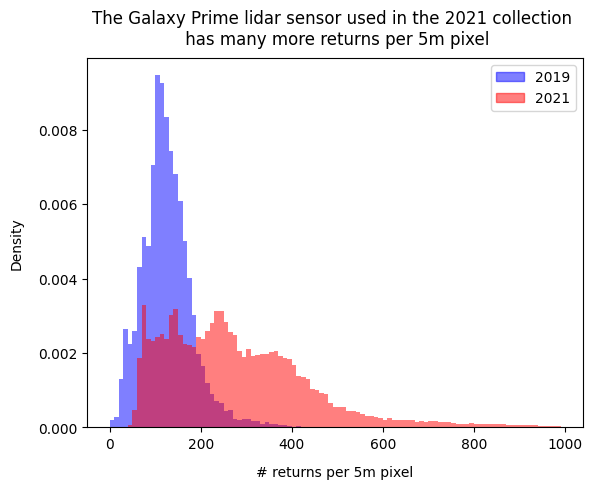

In [430]:
return_counts_per_5m_pixel_2019 = np.unique(df_2019_with_ids["uniq_id"].sort_values(), return_counts=True)[1]
return_counts_per_5m_pixel_2021 = np.unique(df_2021_with_ids["uniq_id"].sort_values(), return_counts=True)[1]
plt.hist(return_counts_per_5m_pixel_2019, bins=np.arange(0,500,10), density=True, alpha=0.5, color="blue")
plt.hist(return_counts_per_5m_pixel_2021, bins=np.arange(0,1000,10), density=True, alpha=0.5, color="red")
plt.xlabel("# returns per 5m pixel", labelpad=10)
plt.ylabel("Density", labelpad=10)
plt.title("The Galaxy Prime lidar sensor used in the 2021 collection \n has many more returns per 5m pixel", fontsize=12, pad=10)

legend_elements = [Patch(facecolor="blue", edgecolor="blue", label='2019', alpha=0.5),
                  Patch(facecolor="red", edgecolor="red", label='2021', alpha=0.5)]
plt.legend(handles=legend_elements)
plt.show()

### 4. Calculate relative height percentiles for each 5m pixel and create spatial maps.

### Compare boxplots of 20th, 50th, 75th and 90th ptile heights for 2019 and 2021 

In [440]:
## Let's subset the dataframes to include only the relevant columns
df_2019_sub = pd.concat([df_2019_with_ids["x"], df_2019_with_ids["y"], df_2019_with_ids["uniq_id"], df_2019["relative_height_return"]], axis=1)
df_2021_sub = pd.concat([df_2021_with_ids["x"], df_2021_with_ids["y"], df_2021_with_ids["uniq_id"], df_2021["relative_height_return"]], axis=1)

## Calculate the number of returns per 5 m pixel
return_counts_per_5m_pixel_2019 = pd.DataFrame(np.unique(df_2019_sub["uniq_id"].sort_values(), return_counts=True)).transpose()
return_counts_per_5m_pixel_2021 = pd.DataFrame(np.unique(df_2021_sub["uniq_id"].sort_values(), return_counts=True)).transpose()
return_counts_per_5m_pixel_2019.columns = return_counts_per_5m_pixel_2021.columns = ["uniq_id", "number_of_returns"]

## Let's select only those 5m pixels which have at least 50 returns
return_counts_per_5m_pixel_2019 = return_counts_per_5m_pixel_2019[return_counts_per_5m_pixel_2019["number_of_returns"] > 50].reset_index(drop=True)
return_counts_per_5m_pixel_2021 = return_counts_per_5m_pixel_2021[return_counts_per_5m_pixel_2021["number_of_returns"] > 50].reset_index(drop=True)
valid_5m_pixels_2019 = return_counts_per_5m_pixel_2019["uniq_id"]
valid_5m_pixels_2021 = return_counts_per_5m_pixel_2021["uniq_id"]

## Update df_sub to include only valid 5m pixels (returns > 50)
df_2019_sub = df_2019_sub[df_2019_sub["uniq_id"].isin(valid_5m_pixels_2019)].reset_index(drop=True)
df_2021_sub = df_2021_sub[df_2021_sub["uniq_id"].isin(valid_5m_pixels_2021)].reset_index(drop=True)

In [441]:
## For each uniq_id, calculate relative height percentiles (20th, 30th, 50th, 75th and 90th)

# 2019
ptile_20_2019 = pd.DataFrame(df_2019_sub.groupby(by=["uniq_id"])["relative_height_return"].quantile(0.2).reset_index(drop=True))
ptile_20_2019["RH_ptile"] = 20
ptile_20_2019.columns= ["height", "RH_ptile"]
ptile_30_2019 = pd.DataFrame(df_2019_sub.groupby(by=["uniq_id"])["relative_height_return"].quantile(0.3).reset_index(drop=True))
ptile_30_2019["RH_ptile"] = 30
ptile_30_2019.columns= ["height", "RH_ptile"]
ptile_50_2019 = pd.DataFrame(df_2019_sub.groupby(by=["uniq_id"])["relative_height_return"].quantile(0.5).reset_index(drop=True))
ptile_50_2019["RH_ptile"] = 50
ptile_50_2019.columns= ["height", "RH_ptile"]
ptile_75_2019 = pd.DataFrame(df_2019_sub.groupby(by=["uniq_id"])["relative_height_return"].quantile(0.75).reset_index(drop=True))
ptile_75_2019["RH_ptile"] = 75
ptile_75_2019.columns= ["height", "RH_ptile"]
ptile_90_2019 = pd.DataFrame(df_2019_sub.groupby(by=["uniq_id"])["relative_height_return"].quantile(0.9).reset_index(drop=True))
ptile_90_2019["RH_ptile"] = 90
ptile_90_2019.columns= ["height", "RH_ptile"]

rh_percentiles_2019 = pd.concat([ptile_20_2019, ptile_30_2019, ptile_50_2019, ptile_75_2019, ptile_90_2019], axis=0)
rh_percentiles_2019["year"] = 2019

# 2021
ptile_20_2021 = pd.DataFrame(df_2021_sub.groupby(by=["uniq_id"])["relative_height_return"].quantile(0.2).reset_index(drop=True))
ptile_20_2021["RH_ptile"] = 20
ptile_20_2021.columns= ["height", "RH_ptile"]
ptile_30_2021 = pd.DataFrame(df_2021_sub.groupby(by=["uniq_id"])["relative_height_return"].quantile(0.3).reset_index(drop=True))
ptile_30_2021["RH_ptile"] = 30
ptile_30_2021.columns= ["height", "RH_ptile"]
ptile_50_2021 = pd.DataFrame(df_2021_sub.groupby(by=["uniq_id"])["relative_height_return"].quantile(0.5).reset_index(drop=True))
ptile_50_2021["RH_ptile"] = 50
ptile_50_2021.columns= ["height", "RH_ptile"]
ptile_75_2021 = pd.DataFrame(df_2021_sub.groupby(by=["uniq_id"])["relative_height_return"].quantile(0.75).reset_index(drop=True))
ptile_75_2021["RH_ptile"] = 75
ptile_75_2021.columns= ["height", "RH_ptile"]
ptile_90_2021 = pd.DataFrame(df_2021_sub.groupby(by=["uniq_id"])["relative_height_return"].quantile(0.9).reset_index(drop=True))
ptile_90_2021["RH_ptile"] = 90
ptile_90_2021.columns= ["height", "RH_ptile"]

rh_percentiles_2021 = pd.concat([ptile_20_2021, ptile_30_2021, ptile_50_2021, ptile_75_2021, ptile_90_2021], axis=0)
rh_percentiles_2021["year"] = 2021

## Combine 2019 and 2021 dataframes
rh_percentiles_combined = pd.concat([rh_percentiles_2019, rh_percentiles_2021], axis=0)

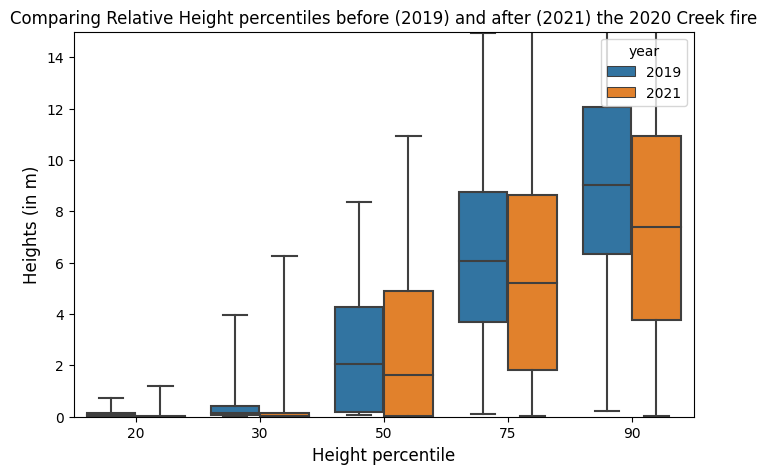

In [443]:
## Compare boxplots
plt.subplots(figsize=(8,5))
sns.boxplot(x=rh_percentiles_combined["RH_ptile"], y=rh_percentiles_combined["height"], hue=rh_percentiles_combined["year"],
           fliersize=0, whis=[5,95])
plt.ylim(0,15)
plt.xlabel("Height percentile", fontsize=12)
plt.ylabel("Heights (in m)", fontsize=12)
plt.title("Comparing Relative Height percentiles before (2019) and after (2021) the 2020 Creek fire")
plt.show()